<a href="https://colab.research.google.com/github/vladoossss/House_price_prediction-CV-/blob/main/hp_final_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/My Drive/House_prices

Mounted at /content/drive
/content/drive/My Drive/House_prices


In [ ]:
import pandas as pd
import numpy as np
import glob
import cv2
import os
import matplotlib.pyplot as plt
import pickle
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from tqdm.auto import tqdm
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.metrics import r2_score

# Loading text data

In [ ]:
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]
text_data = pd.read_csv('HousesInfo.txt', sep=' ', names=cols)

text_data['bathPerBedroom'] = text_data.apply(lambda row: row.bedrooms / row.bathrooms, axis = 1)
text_data['bedroomsPerArea'] = text_data.apply(lambda row: row.area / row.bedrooms, axis = 1)

text_data.head()

,bedrooms,bathrooms,area,zipcode,price,bathPerBedroom,bedroomsPerArea
0,4,4.0,4053,85255,869500,1.000000,1013.250000
1,4,3.0,3343,36372,865200,1.333333,835.750000
2,3,4.0,3923,85266,889000,0.750000,1307.666667
3,5,5.0,4022,85262,910000,1.000000,804.400000
4,3,4.0,4116,85266,971226,0.750000,1372.000000


In [ ]:
x_text = text_data.drop(['price'], axis=1)

# стандартизация переменных
sc = StandardScaler()
sc.fit(x_text)

#преобразование данных
x_text = sc.transform(x_text)
x_text = torch.tensor(x_text.astype('float32'))
x_text

tensor([[ 0.5366,  1.3429,  1.3798, -0.7964, -0.8524,  1.3179],
        [ 0.5366,  0.3370,  0.7995, -7.6474,  0.0214,  0.5851],
        [-0.3255,  1.3429,  1.2736, -0.7949, -1.5077,  2.5335],
        ...,
        [-0.3255, -0.6689, -0.2868,  0.5036,  0.4582, -0.0937],
        [ 0.5366,  0.3370, -0.0432,  0.5036,  0.0214, -0.4791],
        [ 1.3988,  0.3370,  1.1698,  0.5036,  0.8951,  0.2690]])

In [ ]:
y = text_data.price
len(y)

535

In [ ]:
# converting the target into torch format
y = y.astype(int)
y = torch.from_numpy(np.array(y).astype('float32'))
y.shape

torch.Size([535])

# Loading images

In [ ]:
def load_house_images(df, inputPath):
  # initialize our images array (i.e., the house images themselves)
  images = []

  # loop over the indexes of the houses
  for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    basePath = os.path.sep.join([inputPath, "{}_*".format(i + 1)])
    housePaths = sorted(list(glob.glob(basePath)))

    # initialize our list of input images along with the output image
    # after *combining* the four input images
    inputImages = []
    outputImage = np.zeros((128, 128, 3), dtype="uint8")

    # loop over the input house paths
    for housePath in housePaths:
      # load the input image, resize it to be 32 32, and then
      # update the list of input images
      image = cv2.imread(housePath)
      image = cv2.resize(image, (64, 64))
      inputImages.append(image)

    # tile the four input images in the output image such the first
    # image goes in the top-right corner, the second image in the
    # top-left corner, the third image in the bottom-right corner,
    # and the final image in the bottom-left corner
    outputImage[0:64, 0:64] = inputImages[0]
    outputImage[0:64, 64:128] = inputImages[1]
    outputImage[64:128, 64:128] = inputImages[2]
    outputImage[64:128, 0:64] = inputImages[3]

    outputImage = outputImage / 255.0
    outputImage = outputImage.astype('float32')

    # add the tiled image to our set of images the network will be
    # trained on
    images.append(outputImage)

  # return our set of images
  return np.array(images)

In [ ]:
images = load_house_images(text_data, "Houses Dataset/")

In [ ]:
# сохраняем картинки
#with open('images.pickle', 'wb') as f:
#    pickle.dump(images, f)

# загружаем картинки
with open('images.pickle', 'rb') as f:
    data_new = pickle.load(f)

In [ ]:
data_new[0]

array([[[0.5529412 , 0.6784314 , 0.7529412 ],
        [0.43137255, 0.56078434, 0.6666667 ],
        [0.36078432, 0.56078434, 0.6745098 ],
        ...,
        [0.34901962, 0.38431373, 0.48235294],
        [0.25882354, 0.19607843, 0.2627451 ],
        [0.20392157, 0.16078432, 0.24705882]],

       [[0.5686275 , 0.70980394, 0.7490196 ],
        [0.5019608 , 0.65882355, 0.73333335],
        [0.34117648, 0.5137255 , 0.6313726 ],
        ...,
        [0.3882353 , 0.40784314, 0.5294118 ],
        [0.19215687, 0.29411766, 0.40784314],
        [0.04705882, 0.08235294, 0.18431373]],

       [[0.39215687, 0.5411765 , 0.6156863 ],
        [0.45490196, 0.59607846, 0.67058825],
        [0.4       , 0.5764706 , 0.6862745 ],
        ...,
        [0.09019608, 0.12941177, 0.21176471],
        [0.29411766, 0.36862746, 0.5176471 ],
        [0.27058825, 0.3882353 , 0.5176471 ]],

       ...,

       [[0.6117647 , 0.62352943, 0.68235296],
        [0.6784314 , 0.64705884, 0.6666667 ],
        [0.7137255 , 0

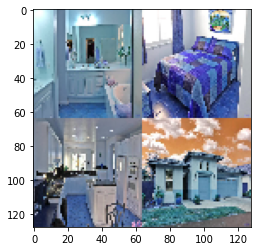

(535, 128, 128, 3)

In [ ]:
plt.imshow(data_new[500])
plt.show()

data_new.shape

In [ ]:
# converting training images into torch format
data_new = data_new.reshape(535, 3, 128, 128)
data_new  = torch.from_numpy(data_new)

# shape of training data
data_new.shape

torch.Size([535, 3, 128, 128])

# Model 1 (own)

## Dataset and Dataloader

In [ ]:
class Images(Dataset):
    def __init__(self, images, x_text, prices):
        """Init function should not do any heavy lifting, but
            must initialize how many items are available in this data set.
        """
        self.image = images
        self.text = x_text
        self.price = prices

    def __len__(self):
        """return number of points in our dataset"""

        return len(self.image)

    def __getitem__(self, idx):
        """ Here we have to return the item requested by `idx`
            The PyTorch DataLoader class will use this method to make an iterable for
            our training or validation loop.
        """
        img = self.image[idx]
        txt = self.text[idx]
        pr = self.price[idx]

        return img, txt, pr

In [ ]:
train_dataset = Images(data_new[:450], x_text[:450], y[:450])
test_dataset = Images(data_new[450:], x_text[450:],y[450:])

In [ ]:
train_loader = DataLoader(train_dataset, batch_size=50)
test_loader = DataLoader(test_dataset, batch_size=50)

## Network architecture

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3,32, kernel_size=3, stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32,64,kernel_size=3, stride=1, padding=0)
        self.bn2 = nn.BatchNorm2d(64)
        self.fc1 = nn.Linear(57604, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 1)

    def forward(self, x, x_text):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = F.max_pool2d(x,2)

        x = x.reshape(x.size(0), -1)   # флаттенинг
        x = torch.cat([x, x_text], 1)  # соединяем фичи, полученные из картинок с табличными данными

        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        output = self.fc3(x)

        return output

## Training and testing the model

In [ ]:
model = ConvNet()
criterion = nn.MSELoss()

num_epochs = 10
learning_rate = 0.001

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
for i, epoch in enumerate(range(num_epochs)):
  epoch_r2_train = 0
  for images, texts, labels in train_loader:
    model.train()
    # Прямой запуск
    outputs = model(images, texts)
    outputs = outputs.view(len(images),) 
    loss = criterion(outputs, labels)

    # Обратное распространение и оптимизатор
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_r2_train += r2_score(labels.detach().numpy(),outputs.detach().numpy())

    model.eval()
    all_outputs = torch.tensor([], dtype=torch.float32)
    epoch_r2_test = 0

    with torch.no_grad():
      for images, texts, labels in test_loader:
          outputs = model(images, texts)
          outputs = outputs.view(len(images),) 

          epoch_r2_test += r2_score(labels.detach().numpy(),outputs.detach().numpy())

  print(i, 'Train: ', epoch_r2_train / len(train_loader))
  print(i, 'Test: ', epoch_r2_test / len(test_loader))

0 Train:  0.22860807138424205
0 Test:  -3.8846369839954438
1 Train:  0.3146828078687277
1 Test:  -1.1002203346189912
2 Train:  0.4120233804262195
2 Test:  -11.720888363271126
3 Train:  0.4408086298055974
3 Test:  -1.3914835184362184
4 Train:  0.41674119333082316
4 Test:  -5.842227129972728


KeyboardInterrupt: ignored

In [ ]:
#torch.save(model.state_dict(), 'model.pth')
model.load_state_dict(torch.load('model.pth'))

<All keys matched successfully>

In [ ]:
model.eval()
all_outputs = torch.tensor([], dtype=torch.float32)
epoch_r2 = 0

with torch.no_grad():
    for images, texts, labels in test_loader:
        outputs = model(images, texts)
        outputs = outputs.view(len(images),) 

        all_outputs = torch.cat((all_outputs, outputs))
        epoch_r2 += r2_score(labels.detach().numpy(),outputs.detach().numpy())

print(epoch_r2 / len(test_loader))

-3.5618230505436093


# Model 2 (Transfer learning)

## Update Dataset and Dataloader

In [ ]:
def load_segm_frontal(inputPath):
  # initialize our images array (i.e., the house images themselves)
  images = []

  # loop over the indexes of the houses
  for i in tqdm(range(535)):
    basePath = os.path.sep.join([inputPath, "{}_f*".format((i + 1))])
    housePaths = sorted(list(glob.glob(basePath)))

    # loop over the input house paths
    for housePath in housePaths:
      image = cv2.imread(housePath)
      image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
      image = cv2.resize(image, (256, 256))
      image = image / 255.0
      image = image.astype('float32')
      images.append(image)
      

  return np.array(images)

In [ ]:
images_frontal = load_segm_frontal("Frontals_segmented/")

In [ ]:
# сохраняем картинки
#with open('images_segm_frontal.pickle', 'wb') as f:
#    pickle.dump(images_frontal, f)

# загружаем картинки
with open('images_segm_frontal.pickle', 'rb') as f:
    images_frontal = pickle.load(f)

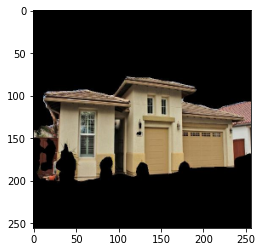

(535, 256, 256, 3)

In [ ]:
plt.imshow(images_frontal[500])
plt.show()

images_frontal.shape

In [ ]:
def inverce(images_frontal):
  new_images = []
  for img in images_frontal:
    img = np.transpose(img, (2, 0, 1))
    new_images.append(img)

  return np.array(new_images)

In [ ]:
new_images = inverce(images_frontal)
new_images.shape

(535, 3, 256, 256)

In [ ]:
# converting training images into torch format
images_frontal  = torch.from_numpy(new_images)

# shape of training data
images_frontal.shape

torch.Size([535, 3, 256, 256])

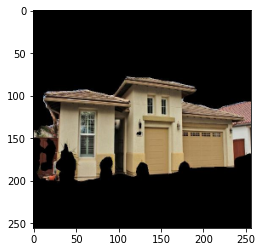

In [ ]:
#look at single image
plt.imshow(images_frontal[500].permute(1,2,0).numpy())
plt.show()

In [ ]:
# разобьем данные на train и test, чтобы можно было проверить качество модели
from sklearn.model_selection import train_test_split

images_frontal_train, images_frontal_test, x_text_train, x_text_test, y_train, y_test = train_test_split(images_frontal, x_text, 
                                                                              y, test_size=0.2, random_state=42)

In [ ]:
train_dataset = Images(images_frontal_train, x_text_train, y_train)
test_dataset = Images(images_frontal_test, x_text_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=30, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=30, shuffle=False)

## Network architecture

In [ ]:
from torchvision import models
#dir(models)

In [ ]:
# Download the resnet-101 layers pre-trained model
resnet = models.resnet101(pretrained=True)
resnet

Downloading: "https://download.pytorch.org/models/resnet101-5d3b4d8f.pth" to /root/.cache/torch/hub/checkpoints/resnet101-5d3b4d8f.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [ ]:
#resnet.fc = nn.Linear(2048, 8)

In [ ]:
# замораживаем первые 8 слоев:
ct = 0
for child in resnet.children():
  ct += 1
  if ct < 8:
    for param in child.parameters():
      param.requires_grad = False

In [ ]:
class NN(nn.Module):
    def __init__(self, resnet_pretrained):
        super().__init__()
        self.resnet_pretrained = resnet_pretrained
        self.fc1 = nn.Linear(1000, 256)
        self.drop_layer1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 8)
        self.drop_layer2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(14, 1)
        
    def forward(self, x, x_text):
        x = F.relu(self.resnet_pretrained(x))
        x = self.drop_layer1(F.relu(self.fc1(x)))
        x_img = self.drop_layer2(F.relu(self.fc2(x)))
        
        x = torch.cat([x_img, x_text], 1)  # соединяем фичи, полученные из картинок с табличными данными
        output = self.fc3(x)

        return x_img, output

## Training and testing the model

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available else 'cpu')
device

device(type='cuda', index=0)

In [ ]:
model_2 = NN(resnet)
model_2 = model_2.to(device)
criterion = nn.MSELoss()

num_epochs = 10
learning_rate = 0.001

optimizer = torch.optim.Adam(model_2.parameters(), lr=learning_rate)

In [ ]:
for i, epoch in enumerate(range(num_epochs)):
  epoch_r2_train = 0
  for images, texts, labels in train_loader:
    model_2.train()

    # для GPU
    images, texts, labels = images.to(device), texts.to(device), labels.to(device)

    x_img, outputs = model_2(images, texts)
    outputs = outputs.view(len(images),) 
    loss = criterion(outputs, labels)

    # Обратное распространение и оптимизатор
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_r2_train += r2_score(labels.cpu().detach().numpy(),outputs.cpu().detach().numpy())

    model_2.eval()
    all_outputs = torch.tensor([], dtype=torch.float32)
    epoch_r2_test = 0

    with torch.no_grad():
      for images, texts, labels in test_loader:
          # для GPU
          images, texts, labels = images.to(device), texts.to(device), labels.to(device)

          x_img, outputs = model_2(images, texts)
          outputs = outputs.view(len(images),) 

          epoch_r2_test += r2_score(labels.cpu().detach().numpy(),outputs.cpu().detach().numpy())

  print(i, 'Train: ', epoch_r2_train / len(train_loader))
  print(i, 'Test: ', epoch_r2_test / len(test_loader))
  if (epoch_r2_test / len(test_loader)) > 0.2:
    break

0 Train:  -1.7278906106151721
0 Test:  -2.527307304498242
1 Train:  -1.7525218839630432
1 Test:  -2.2986634981071394
2 Train:  -1.3219803159870056
2 Test:  -1.6605419354078321
3 Train:  -0.46006696645990014
3 Test:  -0.7158425928648824
4 Train:  0.19477736373534274
4 Test:  0.24433947878132253


# Model 3 (Transfer learning + boosting)

## Network architecture

In [ ]:
class NN_img(nn.Module):
    def __init__(self, resnet_pretrained):
        super().__init__()
        self.resnet_pretrained = resnet_pretrained
        self.fc1 = nn.Linear(1000, 256)
        self.drop_layer1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 4)
        self.drop_layer2 = nn.Dropout(0.25)
        self.fc3 = nn.Linear(4, 1)
        
    def forward(self, x):
        x = F.relu(self.resnet_pretrained(x))
        x = self.drop_layer1(F.relu(self.fc1(x)))
        x_img = self.drop_layer2(F.relu(self.fc2(x)))
        output = self.fc3(x_img)

        return x_img, output

In [ ]:
model_3 = NN_img(resnet)
model_3 = model_3.to(device)
criterion = nn.MSELoss()

num_epochs = 7
learning_rate = 0.001

optimizer = torch.optim.Adam(model_3.parameters(), lr=learning_rate)

In [ ]:
for i, epoch in enumerate(range(num_epochs)):
  epoch_r2_train = 0
  for images, texts, labels in train_loader:
    model_3.train()

    # для GPU
    images, texts, labels = images.to(device), texts.to(device), labels.to(device)

    x_img, outputs = model_3(images)
    outputs = outputs.view(len(images),) 
    loss = criterion(outputs, labels)

    # Обратное распространение и оптимизатор
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    epoch_r2_train += r2_score(labels.cpu().detach().numpy(),outputs.cpu().detach().numpy())

    model_3.eval()
    all_outputs = torch.tensor([], dtype=torch.float32)
    epoch_r2_test = 0

    with torch.no_grad():
      for images, texts, labels in test_loader:
          # для GPU
          images, texts, labels = images.to(device), texts.to(device), labels.to(device)

          x_img, outputs = model_3(images)
          outputs = outputs.view(len(images),) 

          epoch_r2_test += r2_score(labels.cpu().detach().numpy(),outputs.cpu().detach().numpy())

  print(i, 'Train: ', epoch_r2_train / len(train_loader))
  print(i, 'Test: ', epoch_r2_test / len(test_loader))

0 Train:  -2.2254940221996966
0 Test:  -2.6679117177559974
1 Train:  -1.946955822852357
1 Test:  -2.6411172493287327
2 Train:  -1.8970441875875401
2 Test:  -2.37889773533394
3 Train:  -1.6400205627234725
3 Test:  -2.1158543532577596
4 Train:  -1.27262337969278
4 Test:  -1.6875969774862158
5 Train:  -0.5063120892350569
5 Test:  -0.06886267578977504
6 Train:  0.3258302677242242
6 Test:  0.2593339411560568


In [ ]:
dataset = Images(images_frontal, x_text, y)
dataloader = DataLoader(dataset, batch_size=30, shuffle=False)

In [ ]:
model_3.eval()
image_features = torch.tensor([], dtype=torch.long)

with torch.no_grad():
  for images, texts, labels in dataloader:
    images, texts, labels = images.to(device), texts.to(device), labels.to(device)

    x_img, outputs = model_3(images)
    image_features = torch.cat((image_features, x_img.cpu()), 0)
    

## Concatenate image features and table data

In [ ]:
image_features.numpy()

array([[      0.  , 1461055.6 ,       0.  ,       0.  ],
       [      0.  , 1852966.8 ,       0.  ,       0.  ],
       [      0.  , 2056984.5 ,       0.  ,       0.  ],
       ...,
       [      0.  ,  423900.72,       0.  ,       0.  ],
       [      0.  ,  361492.4 ,       0.  ,       0.  ],
       [      0.  , 1208140.2 ,       0.  ,       0.  ]], dtype=float32)

In [ ]:
x_text = text_data.drop(['price'], axis=1)
x_text.to_numpy()

array([[4.00000000e+00, 4.00000000e+00, 4.05300000e+03, 8.52550000e+04,
        1.00000000e+00, 1.01325000e+03],
       [4.00000000e+00, 3.00000000e+00, 3.34300000e+03, 3.63720000e+04,
        1.33333333e+00, 8.35750000e+02],
       [3.00000000e+00, 4.00000000e+00, 3.92300000e+03, 8.52660000e+04,
        7.50000000e-01, 1.30766667e+03],
       ...,
       [3.00000000e+00, 2.00000000e+00, 2.01400000e+03, 9.45310000e+04,
        1.50000000e+00, 6.71333333e+02],
       [4.00000000e+00, 3.00000000e+00, 2.31200000e+03, 9.45310000e+04,
        1.33333333e+00, 5.78000000e+02],
       [5.00000000e+00, 3.00000000e+00, 3.79600000e+03, 9.45310000e+04,
        1.66666667e+00, 7.59200000e+02]])

In [ ]:
X = np.concatenate((image_features.numpy(), x_text.to_numpy()), axis=1)
X.shape

(535, 10)

In [ ]:
# стандартизация переменных
sc = StandardScaler()
sc.fit(X)

#преобразование данных
X = sc.transform(X)
X

array([[ 0.45149963,  0.        ,  0.        , ..., -0.7964436 ,
        -0.85236171,  1.31793775],
       [ 0.7233313 ,  0.        ,  0.        , ..., -7.64742733,
         0.02136044,  0.58508829],
       [ 0.85220673,  0.        ,  0.        , ..., -0.79490195,
        -1.50765333,  2.53350449],
       ...,
       [-0.2388345 ,  0.        ,  0.        , ...,  0.50359373,
         0.45822152, -0.09374363],
       [-0.28527664,  0.        ,  0.        , ...,  0.50359373,
         0.02136044, -0.4790917 ],
       [ 0.27478961,  0.        ,  0.        , ...,  0.50359373,
         0.8950826 ,  0.26903406]])

In [ ]:
X = pd.DataFrame(X, columns=['1', '2', '3', '4', 
                             'bedrooms',	'bathrooms',	'area',	'zipcode', 'areaPerBedroom', 'bedroomsPerArea'])

X.drop(['2','3'], axis=1, inplace=True)
X

,1,4,bedrooms,bathrooms,area,zipcode,areaPerBedroom,bedroomsPerArea
0,0.451500,0.451500,0.536639,1.342907,1.379826,-0.796444,-0.852362,1.317938
1,0.723331,0.723331,0.536639,0.337019,0.799482,-7.647427,0.021360,0.585088
2,0.852207,0.852206,-0.325529,1.342907,1.273566,-0.794902,-1.507653,2.533504
3,0.361058,0.361058,1.398807,2.348795,1.354487,-0.795463,-0.852362,0.455653
4,0.597450,0.597450,-0.325529,1.342907,1.431321,-0.794902,-1.507653,2.799119
...,...,...,...,...,...,...,...,...
530,0.116195,0.116196,1.398807,-0.668868,-0.244321,0.503594,3.079388,-1.159506
531,-0.821450,-0.821450,0.536639,0.839963,5.861554,0.503594,-0.477909,6.977394
532,-0.238834,-0.238834,-0.325529,-0.668868,-0.286825,0.503594,0.458222,-0.093744
533,-0.285277,-0.285276,0.536639,0.337019,-0.043244,0.503594,0.021360,-0.479092


In [ ]:
y = text_data.price
y

0      869500
1      865200
2      889000
3      910000
4      971226
        ...  
530    399900
531    460000
532    407000
533    419000
534    615000
Name: price, Length: 535, dtype: int64

## CatBoost

In [ ]:
# разобьем данные на train и test, чтобы можно было проверить качество модели
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
!pip install catboost

In [ ]:
from catboost import CatBoostRegressor

CBmodel = CatBoostRegressor(depth=6, l2_leaf_reg=9, learning_rate=0.1)
CBmodel.fit(X_train, y_train)

In [ ]:
print("R-squared for Train: ", CBmodel.score(X_train, y_train))
print("R-squared for Test: ", CBmodel.score(X_test, y_test))

R-squared for Train:  0.9983561438977512
R-squared for Test:  0.34492999850084816


In [ ]:
pd.DataFrame({'feature_importance': CBmodel.get_feature_importance(), 
              'feature_names': X_train.columns}).sort_values(by=['feature_importance'], 
                                                           ascending=False)

,feature_importance,feature_names
1,52.636067,4
0,29.727613,1
5,4.176868,zipcode
7,3.719250,bedroomsPerArea
4,3.494976,area
6,2.878840,areaPerBedroom
3,2.673725,bathrooms
2,0.692661,bedrooms
